# Inputs

In [1]:
file_names = [
    'Larmor Data/0040hz.csv',
    'Larmor Data/0140hz.csv',
    'Larmor Data/0240hz.csv',
    'Larmor Data/0340hz.csv',
    'Larmor Data/0440hz.csv',
    'Larmor Data/0540hz.csv',
    'Larmor Data/0640hz.csv',
    'Larmor Data/0740hz.csv',
    'Larmor Data/0840hz.csv',
    'Larmor Data/0940hz.csv',
    # 'Larmor Data/1040hz.csv',
    # 'Larmor Data/1140hz.csv',
    # 'Larmor Data/1240hz.csv',
    # 'Larmor Data/1340hz.csv',
]

# Import packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import numpy as np
import scipy.optimize as opt
from scipy.stats import t
from scipy.optimize import curve_fit
# %matplotlib widget

# Load data

In [3]:
data = []
freqs = []
for file_name in file_names:
    freq = int(file_name.split('/')[-1].split('hz')[0]) + 6_470_000
    df = pd.read_csv(file_name, header=None, names=['t', 'CH1', 'CH2'])
    df = df.dropna()
    data.append(df)
    freqs.append(freq)

In [4]:
# # Plot the data
# fig, axs = plt.subplots(2, 1, figsize=(10, 10))
# for i, df in enumerate(data):
#     axs[0].plot(df['t'], df['CH1'], label=f'{freqs[i]} Hz')
#     axs[1].plot(df['t'], df['CH2'], label=f'{freqs[i]} Hz')
# axs[0].set_title('CH1')
# axs[1].set_title('CH2')
# axs[0].legend()
# axs[1].legend()
# plt.show()

# Fit data to decaying complex sinusoid

   Dataset  Real_T2star  Real_Larmor Frequency   Imag_T2star  \
0        1     0.001397             487.775325      0.000959   
1        2     0.001321             440.690890      0.001066   
2        3     0.001016             371.229006      0.001370   
3        4     0.000948             276.539968      0.001741   
4        5     0.001317            -194.540169      0.002574   
5        6     0.001442            -177.622200 -15296.867998   
6        7     0.000866            -240.803531      0.002466   
7        8     0.000970            -347.445717      0.000010   
8        9     0.001172            -422.378430      0.000964   
9       10     0.001250            -457.787856      0.000884   

   Imag_Larmor Frequency  
0             504.562386  
1             392.639978  
2             323.474660  
3             273.458997  
4            -253.464696  
5            -297.285399  
6            -270.006872  
7            -353.191772  
8            -363.244129  
9            -462.019150 

/var/folders/px/wy4h6r3d0pjcgpg5tm4lrp9h0000gn/T/ipykernel_43730/2636658091.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_imag, _ = curve_fit(model_cos, t, imag_signal, p0=p0)


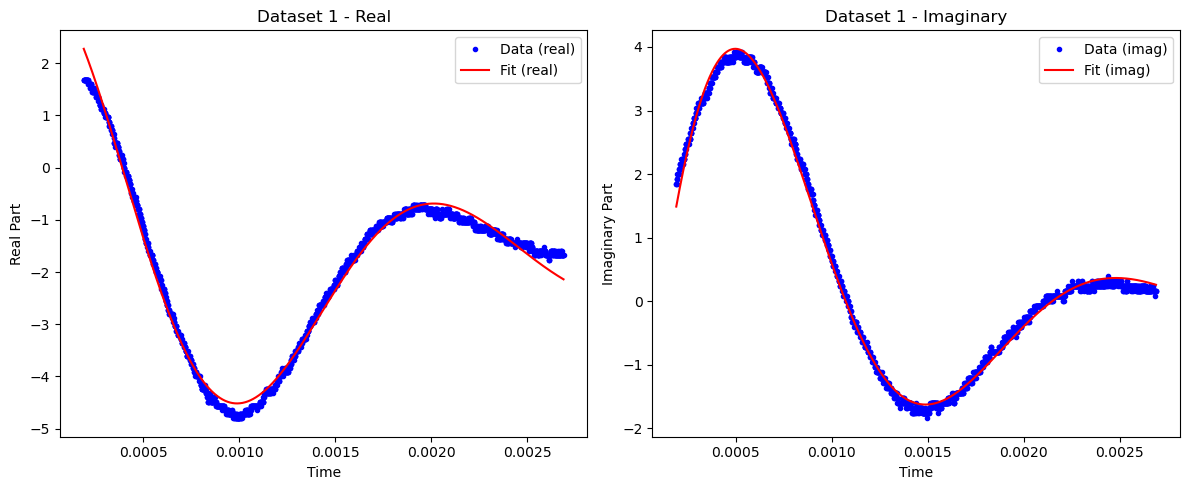

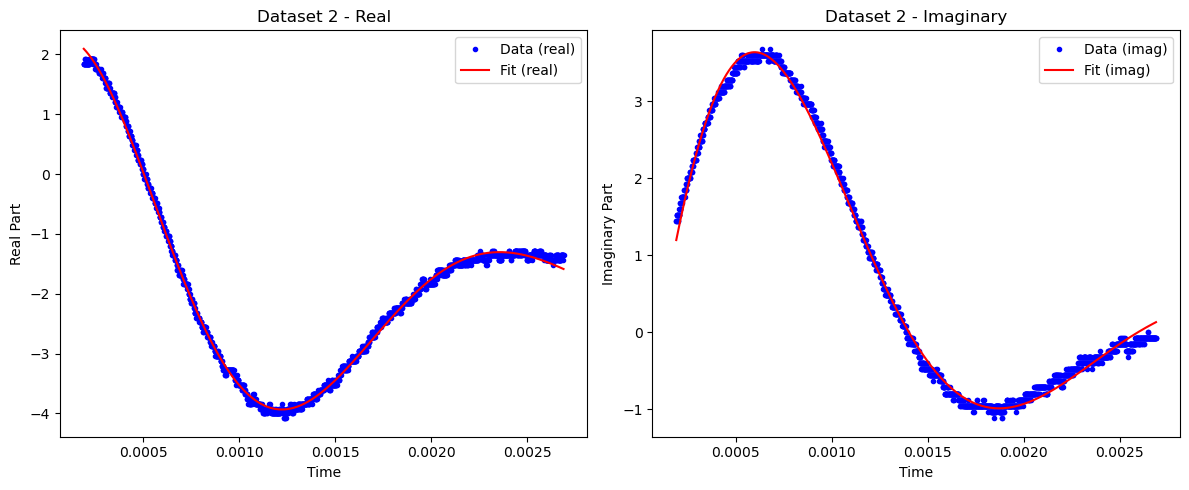

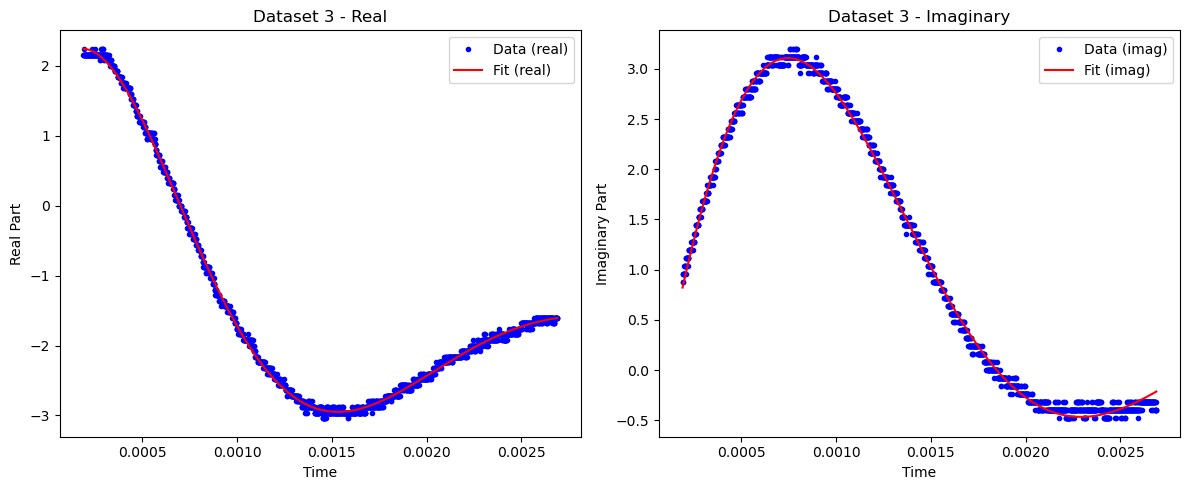

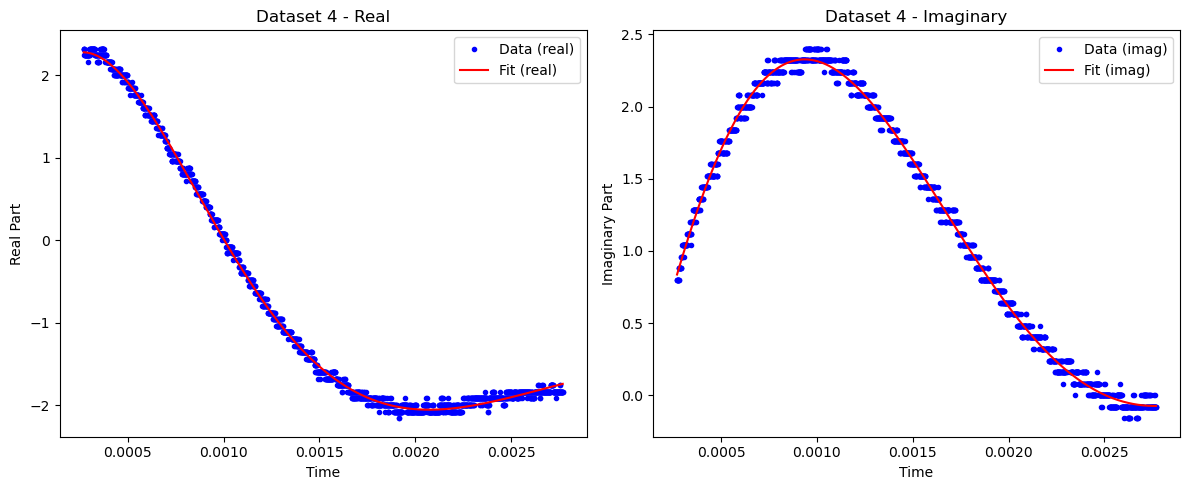

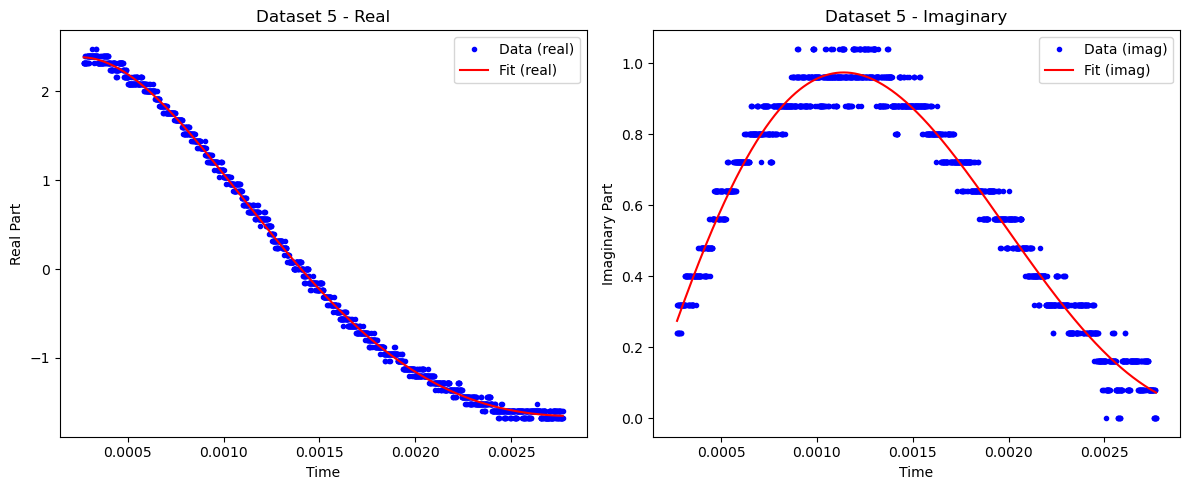

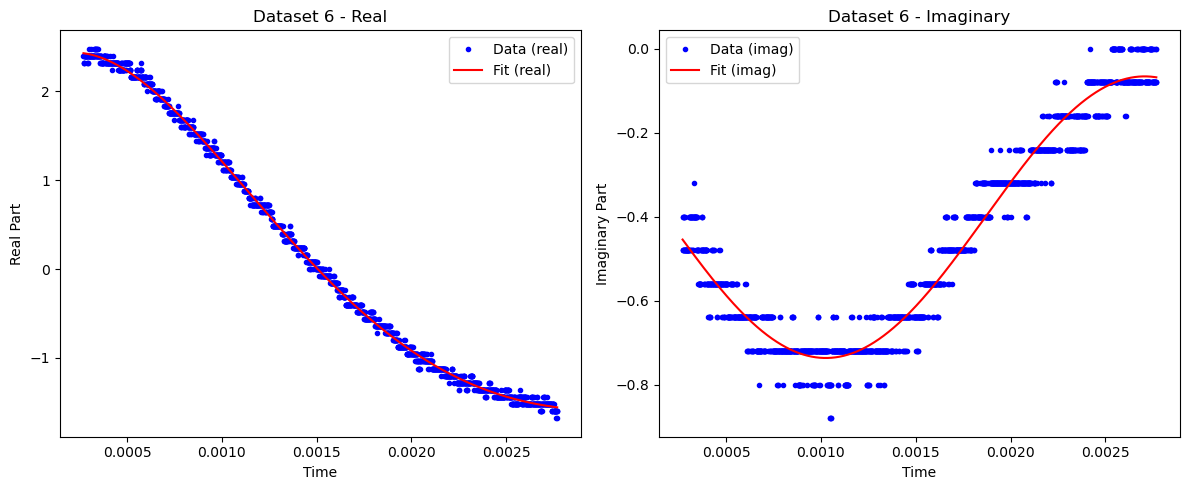

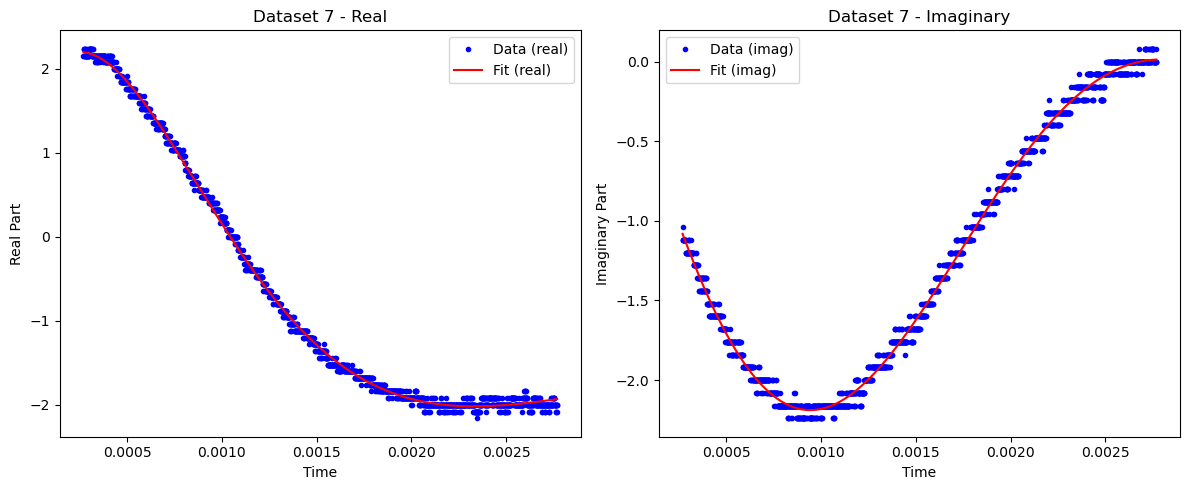

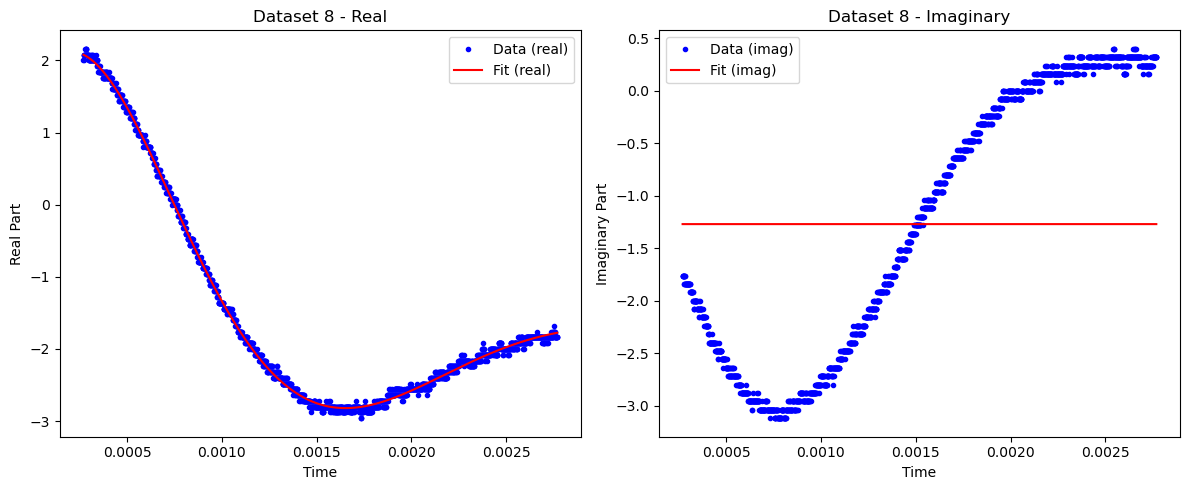

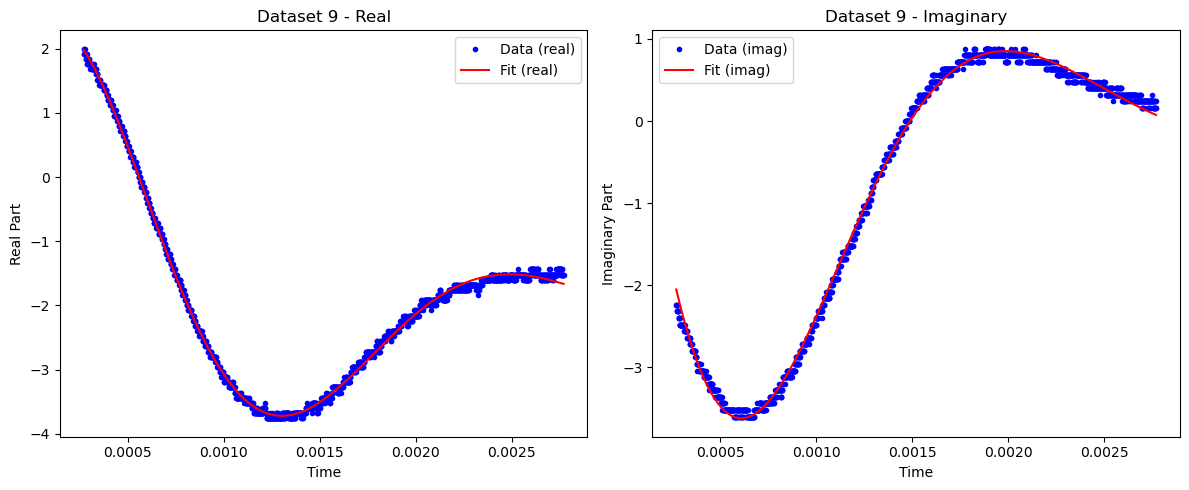

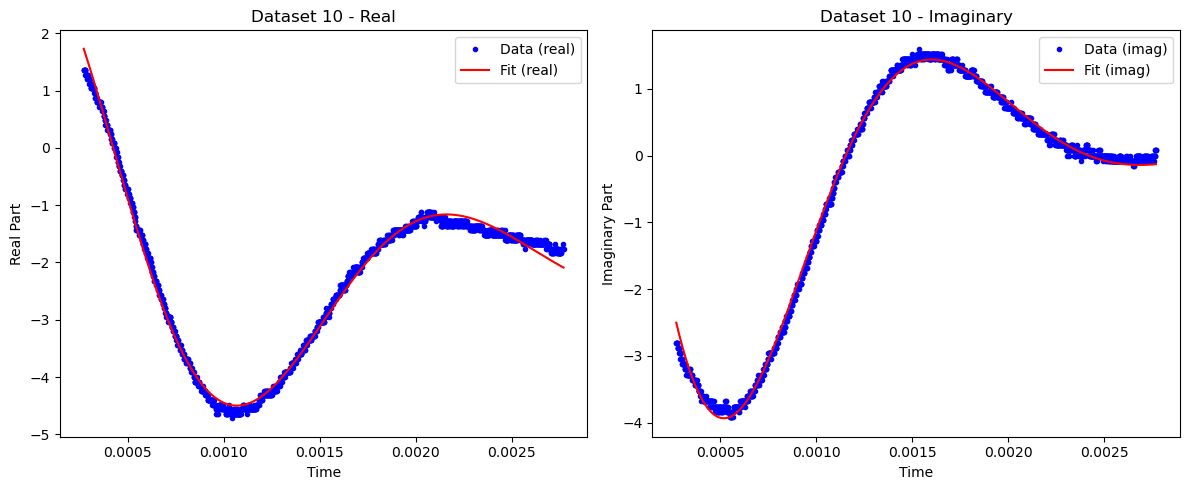

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

def model_cos(t, A, T2star, gamma, delta, C):
    return A * np.exp(-t/T2star) * np.cos(2*np.pi*gamma*t + delta) + C

results = []
fits = []  # to store fitted parameters and data for plotting

for idx, (df, freq) in enumerate(zip(data, freqs)):
    t = df['t'].values
    real_signal = df['CH1'].values
    imag_signal = df['CH2'].values

    # initial guess: A, T2star, gamma, delta, C
    p0 = [1.0, np.median(t),  6_470_400 - freq, 0.0, 0.0]
    popt_real, _ = curve_fit(model_cos, t, real_signal, p0=p0)
    popt_imag, _ = curve_fit(model_cos, t, imag_signal, p0=p0)
    
    results.append({
        'Dataset': idx+1,
        'Real_T2star': popt_real[1],
        'Real_Larmor Frequency': popt_real[2],
        'Imag_T2star': popt_imag[1],
        'Imag_Larmor Frequency': popt_imag[2],
    })
    
    fits.append((t, real_signal, imag_signal, popt_real, popt_imag, freq))

results_df = pd.DataFrame(results)
print(results_df)

for idx, (t, real_signal, imag_signal, popt_real, popt_imag, freq) in enumerate(fits):
    fitted_real = model_cos(t, *popt_real)
    fitted_imag = model_cos(t, *popt_imag)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(t, real_signal, 'b.', label='Data (real)')
    plt.plot(t, fitted_real, 'r-', label='Fit (real)')
    plt.xlabel('Time')
    plt.ylabel('Real Part')
    plt.title(f'Dataset {idx+1} - Real')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(t, imag_signal, 'b.', label='Data (imag)')
    plt.plot(t, fitted_imag, 'r-', label='Fit (imag)')
    plt.xlabel('Time')
    plt.ylabel('Imaginary Part')
    plt.title(f'Dataset {idx+1} - Imaginary')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

0.07999999999999918 0.07999999999999963 0.07999999999999918


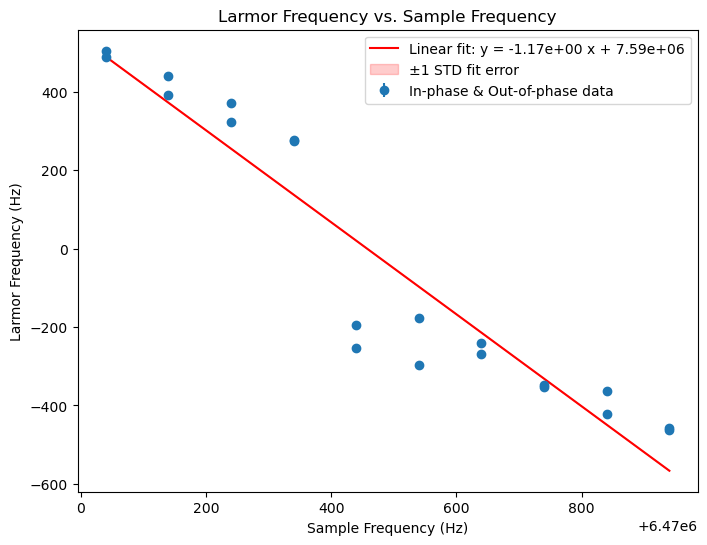

In [ ]:
# Combine in-phase (real) and out-of-phase (imaginary) measurements into one dataset.
xdata = []
ydata = []
for idx, (df, freq) in enumerate(zip(data, freqs)):
    t, real_signal, imag_signal, popt_real, popt_imag, f = fits[idx]
    # Add sample frequency offset to the fitted gamma to get the actual Larmor frequency.
    larmor_in = popt_real[2]
    larmor_out = popt_imag[2]
    xdata.extend([f, f])
    ydata.extend([larmor_in, larmor_out])

xdata = np.array(xdata)
ydata = np.array(ydata)

# Estimate the measurement resolution using the minimum difference between unique voltage levels.
all_real = np.concatenate([df['CH1'].values for df in data])
all_imag = np.concatenate([df['CH2'].values for df in data])
res_real = np.min(np.diff(np.sort(np.unique(all_real))))
res_imag = np.min(np.diff(np.sort(np.unique(all_imag))))
resolution = min(res_real, res_imag)

# Define the linear model.
def linear_model(x, m, b):
    return m * x + b

# Use the resolution as the standard deviation for all data points.
sigma = np.full_like(xdata, resolution, dtype=float)

# Perform the weighted linear least squares fit.
popt_lin, pcov_lin = curve_fit(linear_model, xdata, ydata, sigma=sigma, absolute_sigma=True)
m, b = popt_lin

# Compute ±1 STD error of the linear fit predictions.
x_fit = np.linspace(np.min(xdata), np.max(xdata), 100)
y_fit = linear_model(x_fit, m, b)
y_fit_err = np.array([np.sqrt((x_i**2)*pcov_lin[0, 0] + pcov_lin[1, 1] + 2*x_i*pcov_lin[0, 1]) for x_i in x_fit])

# Plot the in-phase and out-of-phase data with the linear fit and error bands.
plt.figure(figsize=(8, 6))
plt.errorbar(xdata, ydata, yerr=resolution, fmt='o', label='In-phase & Out-of-phase data')
plt.plot(x_fit, y_fit, 'r-', label=f'Linear fit: y = {m:.2e} x + {b:.2e}')
plt.fill_between(x_fit, y_fit - y_fit_err, y_fit + y_fit_err, color='r', alpha=0.2, label='±1 STD fit error')
plt.xlabel('Sample Frequency (Hz)')
plt.ylabel('Larmor Frequency (Hz)')
plt.title('Larmor Frequency vs. Sample Frequency')
plt.legend()
plt.show()


Larmor frequency: 6470498.62855669 ± 1.10e-01


/var/folders/px/wy4h6r3d0pjcgpg5tm4lrp9h0000gn/T/ipykernel_43730/2325232830.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_imag, pcov_imag = curve_fit(model_cos, t, imag_signal, p0=p0)


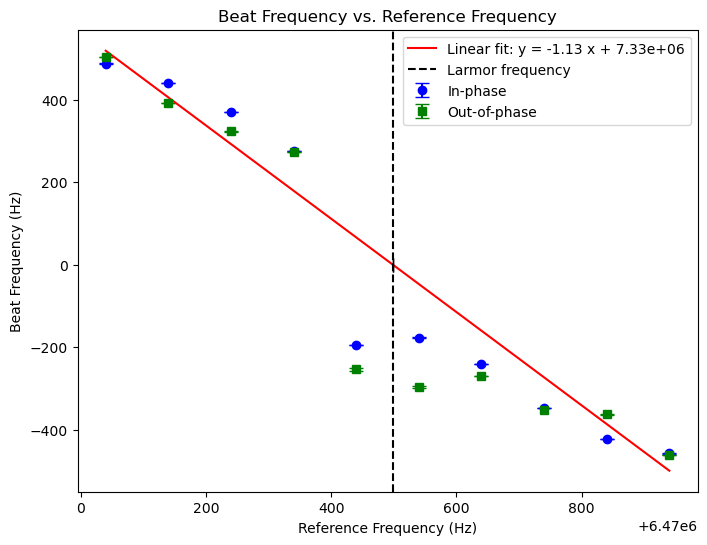

In [67]:
# Recompute the frequency fits to obtain the frequency sigma from the covariance matrix.
xdata = []
ydata = []
yerr = []
labels = []

for idx, (df, sample_freq) in enumerate(zip(data, freqs)):
    t = df['t'].values
    real_signal = df['CH1'].values
    imag_signal = df['CH2'].values

    # Initial guess: A, T2star, gamma, delta, C.
    p0 = [1.0, np.median(t), 6_470_400 - sample_freq, 0.0, 0.0]
    popt_real, pcov_real = curve_fit(model_cos, t, real_signal, p0=p0)
    popt_imag, pcov_imag = curve_fit(model_cos, t, imag_signal, p0=p0)

    # The "beat frequency" is the fitted gamma parameter.
    beat_in = popt_real[2]
    beat_out = popt_imag[2]
    sigma_in = np.sqrt(pcov_real[2, 2])
    sigma_out = np.sqrt(pcov_imag[2, 2])
    
    # Store sample frequency (x-axis), beat frequency (y-axis), and the sigma from the fit.
    xdata.append(sample_freq)
    ydata.append(beat_in)
    yerr.append(sigma_in)
    labels.append('In-phase')
    
    xdata.append(sample_freq)
    ydata.append(beat_out)
    yerr.append(sigma_out)
    labels.append('Out-of-phase')

xdata = np.array(xdata)
ydata = np.array(ydata)
yerr = np.array(yerr)

# Define the linear model.
def linear_model(x, m, b):
    return m * x + b

# Perform weighted linear least squares using the frequency sigma as standard deviations.
popt_lin, pcov_lin = curve_fit(linear_model, xdata, ydata, sigma=yerr, absolute_sigma=True)
m, b = popt_lin

# Compute the x-intercept of the linear fit (where y = 0), i.e. x0 = -b/m.
x_intercept = -b / m

# Create points for plotting the linear fit.
x_fit = np.linspace(np.min(xdata), np.max(xdata), 100)
y_fit = linear_model(x_fit, m, b)

# Plot the data with error bars (with caps), labeling in-phase and out-of-phase separately.
plt.figure(figsize=(8, 6))
# Plot in-phase data.
mask_in = np.array(labels) == 'In-phase'
plt.errorbar(xdata[mask_in], ydata[mask_in], yerr=yerr[mask_in],
             fmt='bo', capsize=5, label='In-phase')
# Plot out-of-phase data.
mask_out = np.array(labels) == 'Out-of-phase'
plt.errorbar(xdata[mask_out], ydata[mask_out], yerr=yerr[mask_out],
             fmt='gs', capsize=5, label='Out-of-phase')

# Plot the linear fit.
plt.plot(x_fit, y_fit, 'r-', 
         label=f'Linear fit: y = {m:.2f} x + {b:.2e}')

# Add vertical line at the x-intercept (larmor frequency) with a label.
plt.axvline(x=x_intercept, color='k', linestyle='--', label=f'Larmor frequency')

sigma_x_intercept = np.sqrt((pcov_lin[1,1]/m**2) + ((b**2 * pcov_lin[0,0])/(m**4)) - (2*b*pcov_lin[0,1]/m**3))
print(f'Larmor frequency: {x_intercept} ± {sigma_x_intercept:.2e}')
plt.errorbar(x_intercept, 0, xerr=sigma_x_intercept, fmt='none', ecolor='k', capsize=5)


plt.xlabel('Reference Frequency (Hz)')
plt.ylabel('Beat Frequency (Hz)')
plt.title('Beat Frequency vs. Reference Frequency')
plt.legend()
plt.show()
